(1055, 50, 1)
(1, 50, 1)
Train on 7381 samples, validate on 2109 samples
Epoch 1/1000
7381/7381 [==============================] - 13s 2ms/sample - loss: 0.0156 - last_time_step_mse: 0.0147 - val_loss: 0.0076 - val_last_time_step_mse: 0.0070
Epoch 2/1000
7381/7381 [==============================] - 12s 2ms/sample - loss: 0.0073 - last_time_step_mse: 0.0068 - val_loss: 0.0071 - val_last_time_step_mse: 0.0069
Epoch 3/1000
7381/7381 [==============================] - 12s 2ms/sample - loss: 0.0070 - last_time_step_mse: 0.0068 - val_loss: 0.0069 - val_last_time_step_mse: 0.0068
Epoch 4/1000
7381/7381 [==============================] - 12s 2ms/sample - loss: 0.0069 - last_time_step_mse: 0.0067 - val_loss: 0.0068 - val_last_time_step_mse: 0.0068
Epoch 5/1000
7381/7381 [==============================] - 12s 2ms/sample - loss: 0.0067 - last_time_step_mse: 0.0067 - val_loss: 0.0067 - val_last_time_step_mse: 0.0068
Epoch 6/1000
7381/7381 [==============================] - 11s 2ms/sample - loss: 0

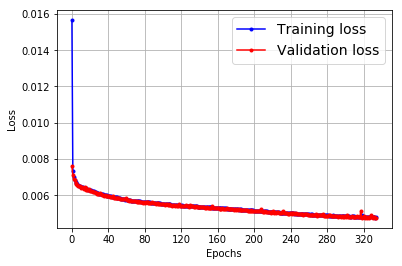

In [0]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import sklearn
import sys
import io

def plot_learning_curves(loss, val_loss):
    plt.figure()
    plt.plot(np.arange(len(loss)), loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)), val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

n_steps = 50
forecast = 10

#EXTRACT FLOW, Z SCORE, OUTLIERS
data_west = pd.read_csv('denoised_data_1016_west.csv')
data_west_o = np.array(data_west.FLOW)

#EXRTEND DATA
array_to_concatinate = data_west_o[288:]
for iter in range (35):
    data_west_o = np.concatenate([data_west_o,array_to_concatinate])

#SCALE AND RESHAPE DATA
scaler = MinMaxScaler()
array = data_west_o.reshape(-1, 1)
array_scaled = scaler.fit_transform(array)

flow_reshaped = array_scaled[:(len(array_scaled) - (len(array_scaled) % (n_steps+forecast)))].reshape(-1, (n_steps+forecast), 1)
#TRAIN SET, VALIDATION SET, TEST SET
test = int(0.7 * flow_reshaped.shape[0])
valid = int(0.9 * flow_reshaped.shape[0])

X_train = flow_reshaped[:test, :n_steps]
X_valid = flow_reshaped[test:valid, :n_steps]
X_test = flow_reshaped[valid:, :n_steps]
print(X_test.shape)
print(X_test[-1:].shape)

#prepare targets
Y = np.empty((flow_reshaped.shape[0], n_steps, forecast))
for step_ahead in range(1, forecast + 1):
    Y[:, :, step_ahead - 1] = flow_reshaped[:, step_ahead:step_ahead + n_steps, 0]

y_train = Y[:test]
y_valid = Y[test:valid]
y_test = Y[valid:]

#DEFINE AND COMPILE MODEL
model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(forecast))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=1000,
                    validation_data=(X_valid, y_valid), callbacks=[early_stopping_cb])

model.save("gru_1016_west.h5")
plot_learning_curves(history.history["loss"], history.history["val_loss"])